In [6]:
import pandas as pd
import numpy as np

In [7]:
#First of all cleaning and preparing data

In [8]:
df = pd.read_csv(
    r"C:\Users\piotr\Desktop\StudentPerformance.csv",
    encoding='latin1'
)

df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [16]:
for col in df.columns:
    print(col)

hours_studied
previous_scores
extracurricular_activities
sleep_hours
sample_question_papers_practiced
performance_index


In [10]:
df.columns = df.columns.str.lower().str.replace(' ', '_')


In [11]:
df.isnull().sum()

hours_studied                       0
previous_scores                     0
extracurricular_activities          0
sleep_hours                         0
sample_question_papers_practiced    0
performance_index                   0
dtype: int64

In [19]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   hours_studied                     10000 non-null  int64  
 1   previous_scores                   10000 non-null  int64  
 2   extracurricular_activities        10000 non-null  int64  
 3   sleep_hours                       10000 non-null  int64  
 4   sample_question_papers_practiced  10000 non-null  int64  
 5   performance_index                 10000 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 468.9 KB


In [12]:
#Second thing is simple EDA

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df['extracurricular_activities'] = df['extracurricular_activities'].map({'Yes': 1, 'No': 0})


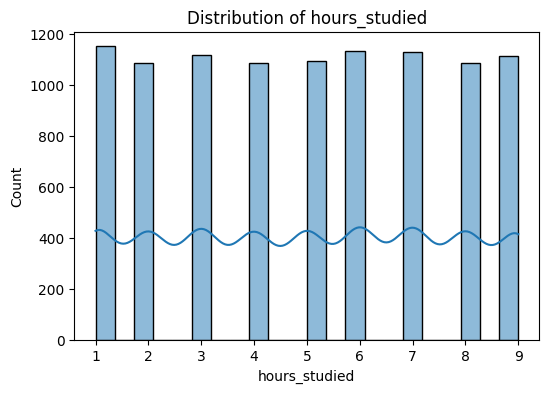

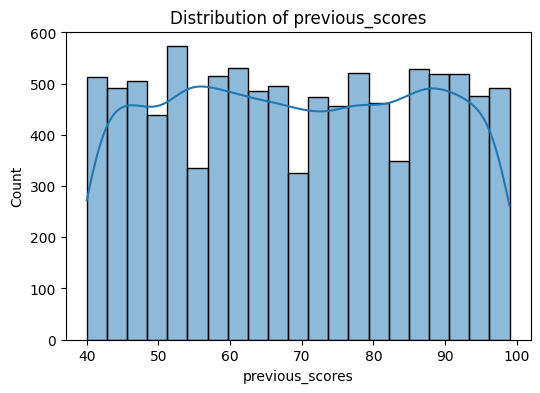

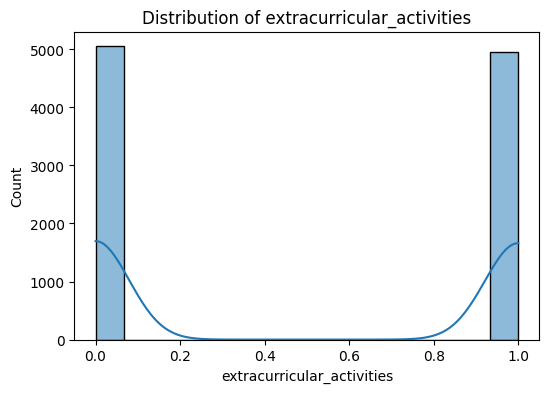

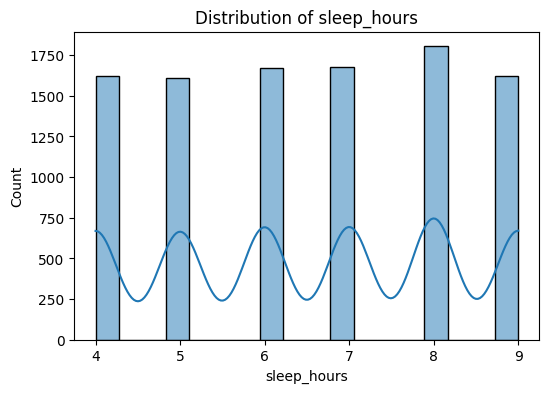

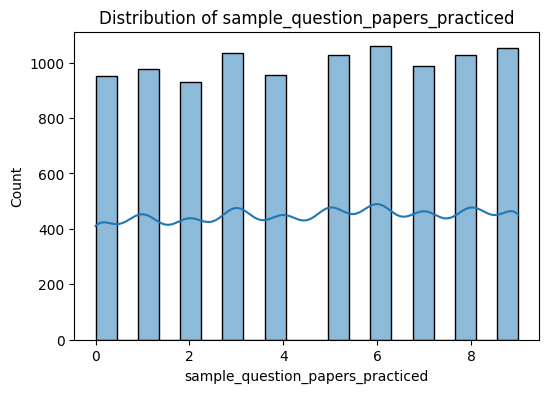

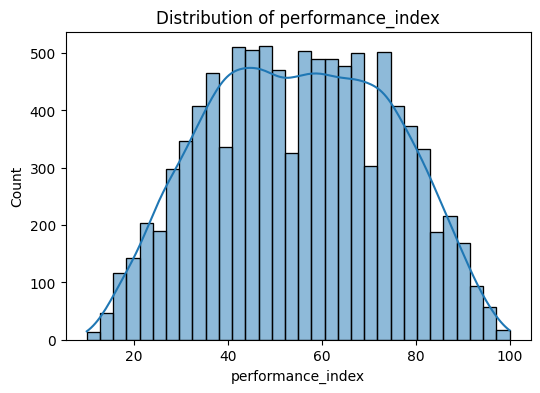

In [20]:
num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


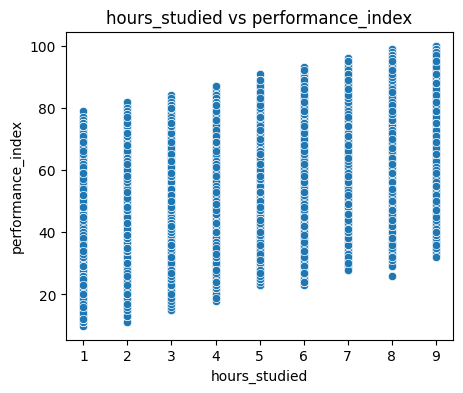

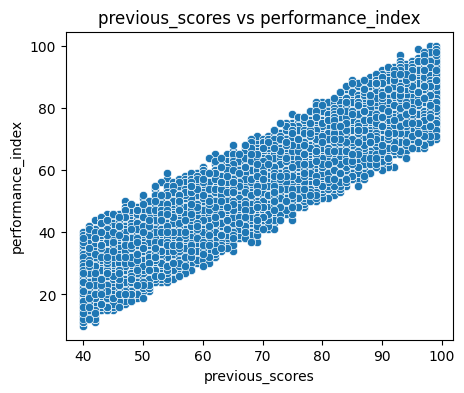

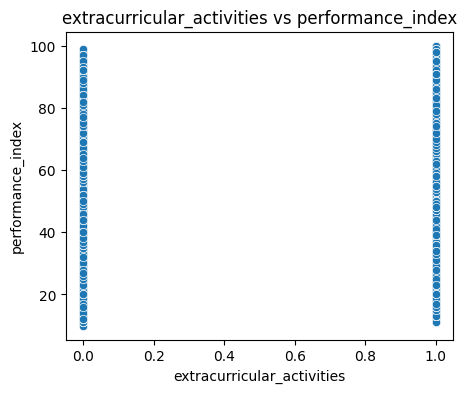

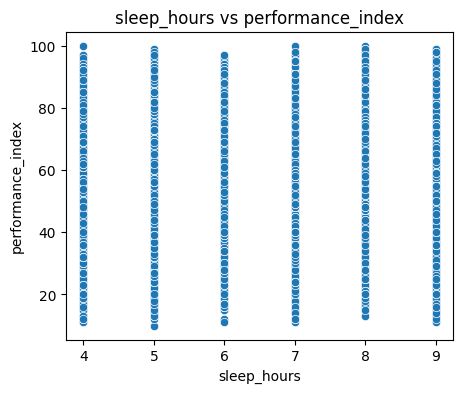

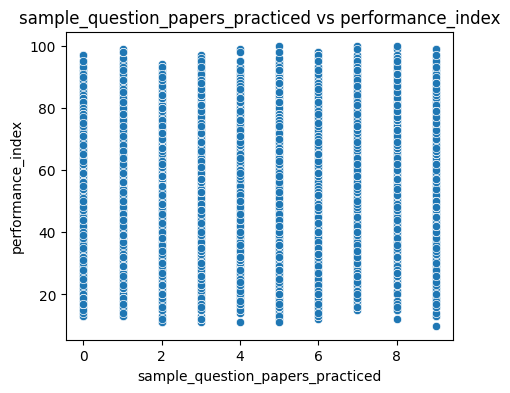

In [22]:
for col in num_cols:
    if col != 'performance_index':
        plt.figure(figsize=(5,4))
        sns.scatterplot(x=df[col], y=df['performance_index'])
        plt.title(f'{col} vs performance_index')
        plt.show()


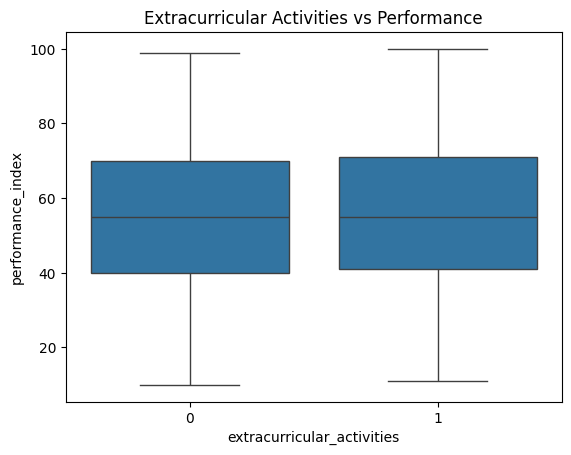

In [23]:
sns.boxplot(
    x='extracurricular_activities',
    y='performance_index',
    data=df
)
plt.title('Extracurricular Activities vs Performance')
plt.show()


In [25]:
df.skew()


hours_studied                      -0.004213
previous_scores                     0.004502
extracurricular_activities          0.020804
sleep_hours                        -0.039474
sample_question_papers_practiced   -0.035636
performance_index                  -0.001740
dtype: float64

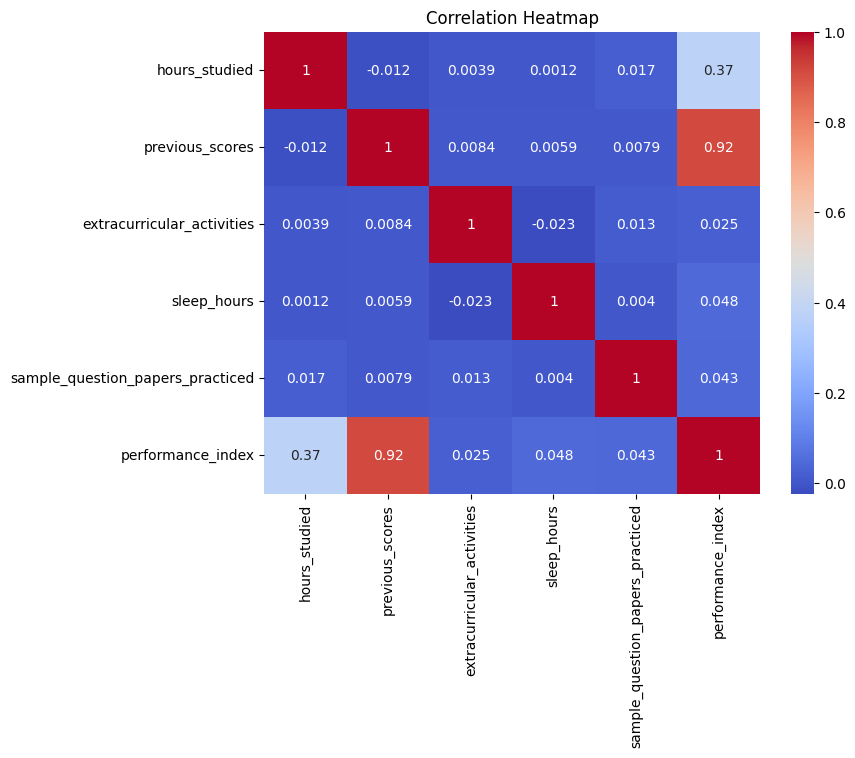

In [26]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df.corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
#Training and evaluating models

In [27]:

n = len(df)
np.random.seed(42)
shuffled_idx = np.random.permutation(n)


n_train = int(0.6 * n)
n_val   = int(0.2 * n)


train_idx = shuffled_idx[:n_train]
val_idx   = shuffled_idx[n_train:n_train+n_val]
test_idx  = shuffled_idx[n_train+n_val:]


df_train = df.iloc[train_idx].reset_index(drop=True)
df_val   = df.iloc[val_idx].reset_index(drop=True)
df_test  = df.iloc[test_idx].reset_index(drop=True)


target = "performance_index"

y_train = df_train[target].values
y_val   = df_val[target].values
y_test  = df_test[target].values

X_train_raw = df_train.drop(columns=[target]).values
X_val_raw   = df_val.drop(columns=[target]).values
X_test_raw  = df_test.drop(columns=[target]).values


X_train = np.c_[np.ones((X_train_raw.shape[0], 1)), X_train_raw]
X_val   = np.c_[np.ones((X_val_raw.shape[0], 1)), X_val_raw]
X_test  = np.c_[np.ones((X_test_raw.shape[0], 1)), X_test_raw]


In [28]:
theta = np.linalg.pinv(X_train.T @ X_train) @ (X_train.T @ y_train)

pred_val = X_val @ theta
pred_test = X_test @ theta


In [29]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

print("Val RMSE:", rmse(y_val, pred_val))
print("Test RMSE:", rmse(y_test, pred_test))


Val RMSE: 2.031443578687793
Test RMSE: 2.046788916654122


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [31]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    max_depth=None
)


rf.fit(X_train_raw, y_train)


pred_val = rf.predict(X_val_raw)
pred_test = rf.predict(X_test_raw)

In [32]:
print("RF Val RMSE:", rmse(y_val, pred_val))
print("RF Test RMSE:", rmse(y_test, pred_test))
print("RF Test R2:", r2_score(y_test, pred_test))

RF Val RMSE: 2.347870611942856
RF Test RMSE: 2.316288325468637
RF Test R2: 0.9856613659426049


In [38]:


rf_importance = pd.Series(rf.feature_importances_, index=df.drop(columns=['performance_index']).columns)\
                  .sort_values(ascending=False)
rf_importance


previous_scores                     0.850440
hours_studied                       0.138212
sample_question_papers_practiced    0.005262
sleep_hours                         0.004728
extracurricular_activities          0.001359
dtype: float64

In [33]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [34]:

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

xgb = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)


xgb.fit(
    X_train_raw, y_train,
    eval_set=[(X_val_raw, y_val)],
    verbose=False
)


pred_val = xgb.predict(X_val_raw)
pred_test = xgb.predict(X_test_raw)


In [37]:
print("XGB Val RMSE:", rmse(y_val, pred_val))
print("XGB Test RMSE:", rmse(y_test, pred_test))
print("XGB Test R2:", r2_score(y_test, pred_test))


XGB Val RMSE: 2.21084437468023
XGB Test RMSE: 2.2249671920947196
XGB Test R2: 0.9867696976962177


In [39]:


xgb_importance = pd.Series(xgb.feature_importances_, index=df.drop(columns=['performance_index']).columns)\
                   .sort_values(ascending=False)
xgb_importance


previous_scores                     0.792265
hours_studied                       0.189698
sleep_hours                         0.007646
sample_question_papers_practiced    0.005915
extracurricular_activities          0.004476
dtype: float32

In [41]:
#The best model according to rmse is linear regression